In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy as cp
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

def grid(n, prob):
    """
    Construct a grid with dimension n with probability prob
    """
    return np.random.choice([0, 1], size=(n, n), p=[prob, 1-prob])



In [5]:
def writing_data(samples, n, prob):
    """
    samples: number of samples (int)
    n: size of matrix  (odd int)
    prob: probability of getting 1 or 0 (0<=prob<=1)
    """
    count = 0.
    mat = []
    vd = np.zeros(samples)
    for ind in range(samples):
        b = grid(n, prob)
        mat.append(cp.copy(b)) #Used copy to not have 2 on the matrix
        b[(n-1)//2][(n-1)//2] = 2
        stop = False
        while not stop:
            change = False
            for i, j in zip(*np.where(b == 2)):
                if i == 0 or j == 0 or i == n - 1 or j == n - 1:
                    count += 1
                    stop = True
                    vd[ind] = 1
                    break
                if b[i+1, j] == 0:
                    b[i+1, j] = 2
                    change = True
                if b[i, j+1] == 0:
                    b[i, j+1] = 2
                    change = True
                if b[i-1, j] == 0:
                    b[i-1, j] = 2
                    change = True
                if b[i, j-1] == 0:
                    b[i, j-1] = 2
                    change = True
            if not change:
                stop = True
    return np.array(mat),vd

# Build a model

In this case I use a simple Neural Network with one input layer and one hidden layer with output 0 (if the matrix don't percolate) or 1 (if the matrix percolate).

In [ ]:
n = 15
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(n, n)),
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Make the Training data

In [ ]:
#traning data
td,tr = writing_data(1000,n,0.5)

# Show sample of data

In [ ]:
plt.imshow(td[0])
print(tr[0])

# Training the model

In [ ]:
history = model.fit(td,tr, epochs = 12)

# Testing the model

In [ ]:
test_mat,test_v = writing_data(100,n,0.6)
test_loss, test_acc = model.evaluate(test_mat, test_v)
print('Test accuracy:', test_acc)

# Plotting the probability versus the accuracy of the method

We have a plot that shows that the accuracy decreases on the critical probability for the model.

The way to acquire data for the plot is given in the line below the plot

In [ ]:
plt.plot(probability,acc, 'o')
plt.show()

In [ ]:
probability = np.linspace(0.,1.,100)
acc = np.zeros(len(probability))
for i,v in enumerate(probability):
    #test data
    test_mat,test_v = writing_data(100,n,v)
    #evaluate accuracy
    test_loss, test_acc = model.evaluate(test_mat, test_v)
    acc[i] = test_acc

# Building another model

This time I will use Convolutional Neural Networks with 2 convolutional + pooling layers before entering the Neural Network structure that is the same as the previous one.

In [73]:
#traning data
td,tr = writing_data(10000,n,0.5)
vd, vr = writing_data(100,n,0.5)
td = td.reshape(-1,n,n,1)
vd = vd.reshape(-1,n,n,1)

In [91]:
n = 15
model = keras.Sequential([
    keras.layers.Conv2D(64, kernel_size= 3, activation=tf.nn.relu, input_shape=(n,n,1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dense(2, kernel_regularizer=keras.regularizers.l2(0.001), activation=tf.nn.softmax),
])
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [92]:
history = model.fit(td,
                    tr, 
                    epochs = 50,
                    batch_size=512,
                 validation_data=(vd, vr))

Train on 10000 samples, validate on 100 samples
Epoch 1/50
10000/10000 [==============================] - 3s 326us/sample - loss: 0.7563 - acc: 0.5011 - val_loss: 0.7011 - val_acc: 0.5200
Epoch 2/50
10000/10000 [==============================] - 2s 244us/sample - loss: 0.6871 - acc: 0.5378 - val_loss: 0.6882 - val_acc: 0.5200
Epoch 3/50
10000/10000 [==============================] - 2s 246us/sample - loss: 0.6673 - acc: 0.5902 - val_loss: 0.6650 - val_acc: 0.5600
Epoch 4/50
10000/10000 [==============================] - 3s 266us/sample - loss: 0.6302 - acc: 0.6882 - val_loss: 0.6306 - val_acc: 0.6600
Epoch 5/50
10000/10000 [==============================] - 3s 251us/sample - loss: 0.5818 - acc: 0.7190 - val_loss: 0.6025 - val_acc: 0.6500
Epoch 6/50
10000/10000 [==============================] - 3s 256us/sample - loss: 0.5485 - acc: 0.7236 - val_loss: 0.5859 - val_acc: 0.6800
Epoch 7/50
10000/10000 [==============================] - 3s 255us/sample - loss: 0.5366 - acc: 0.7323 - val_los

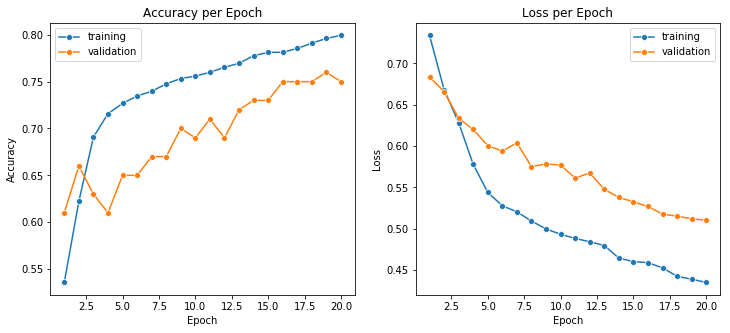

In [90]:
#accuracy
train_accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']

#loss 
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

#Epochs
epoch_range = range(1,len(train_accuracy)+1)

#Plot
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].set_title('Accuracy per Epoch')
sns.lineplot(x=epoch_range,y=train_accuracy,marker='o',ax=ax[0])
sns.lineplot(x=epoch_range,y=validation_accuracy,marker='o',ax=ax[0])
ax[0].legend(['training','validation'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[1].set_title('Loss per Epoch')
sns.lineplot(x=epoch_range,y=train_loss,marker='o',ax=ax[1])
sns.lineplot(x=epoch_range,y=validation_loss,marker='o',ax=ax[1])
ax[1].legend(['training','validation'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

# Plotting the probability versus the accuracy of the method

We have a plot that shows that the accuracy decreases on the critical probability for the model.

The way to acquire data for the plot is given in the line below the plot

In [ ]:
plt.plot(probability,acc, 'o')
plt.show()

Adjusting a Gaussian, the percolation probability is given by

In [ ]:
print("Percolation probability:%.5f" % popt[1])

In [ ]:
probability = np.linspace(0.,1.,50)
acc = np.zeros(len(probability))
for i,v in enumerate(probability):
    #test data
    test_mat,test_v = writing_data(100,n,v)
    test_mat = test_mat.reshape(-1,n,n,1) 
    #evaluate accuracy
    test_loss, test_acc = model.evaluate(test_mat, test_v)
    acc[i] = test_acc

In [ ]:
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))
x = probability
y = 1 - acc

popt,pcov = curve_fit(gaus,x,y, p0=[0.5,0.3,1.])
plt.plot(x,y,'b+:',label='data')
plt.plot(x,gaus(x,*popt),'ro:',label='fit')
plt.legend()
plt.show()

In [ ]:
print("Percolation probability:%.5f" % popt[1])